# Shapiro Diagram Simulation with Resistively Shunt Model

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint

In [59]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(\omega_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\rightarrow I_{DC}/I_C$,

$I_{RF} \rightarrow I_{RF}/I_C$,

$ V \rightarrow I_CR_N$,

$\omega_0=2eI_CR_N/\hbar$,

$\omega_{RF} \rightarrow \omega_{RF}/\omega_0$,

$\omega_0 t \rightarrow t$,

the RSJ model simply becomes:

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(\omega_{RF}t)-\sin\phi]$

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \rightarrow V=\langle\frac{d\phi}{dt}\rangle$

### Cython codes here is to speed up the simulation because python is slower than C:

In [60]:
%%cython
cimport numpy as np
from libc.math cimport sin
import numpy as np

cpdef double CPR(double G):
    '''
        Current-phase relationship for the junction. Normally sinusoidal, can be other function for complex materials.
    '''
    return sin(G)

cpdef double i(double t,double i_dc,double i_ac,double w_rf):
    '''
        Current applied to the junction
    '''
    return i_dc + i_ac * sin(w_rf*t)
    
cpdef dGdt(G,double t,double i_dc,double i_ac,double w_rf):
    '''
        Define G = [gamma]
        dG_dt =  - f(gamma) + i(t)) 
    '''
    der = -CPR(G) + i(t,i_dc,i_ac,w_rf)
    return der 

In [62]:
#f_array = np.array([15e9])#,13e9,7e9,5e9])

w_rf=1.1 # you can adjust the driving frequency here.
IDC_array=np.linspace(-5,5,201)
IRF_array=np.linspace(0,10,201) 

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))

print("Driving RF frequency w_rf = "+str(w_rf))

DC array size: 201
RF array size: 201
Driving RF frequency w_rf = 1.1


In [63]:
T1=datetime.now()
print (T1)
WB_Freq=np.empty([len(IRF_array),len(IDC_array)])
DVDI=np.empty([len(IRF_array),len(IDC_array)])

for i in range(0,len(IRF_array)):
    print("RF current now: "+str(IRF_array[i])+" ,"+str(datetime.now()),end='\r')
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.02,0.02)*2*np.pi/w_rf # 300 periods
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],w_rf))
        WB_Freq[i,j]=np.mean(G_array[:-1500]) # take the average of last 1500 values.
DVDI=np.gradient(WB_Freq,IDC_step,axis=1) #differential resistance dV/dI

print ("It takes " + str(datetime.now()-T1))              
        


2020-09-16 09:53:56.949944


TypeError: float() argument must be a string or a number, not 'datetime.timedelta'

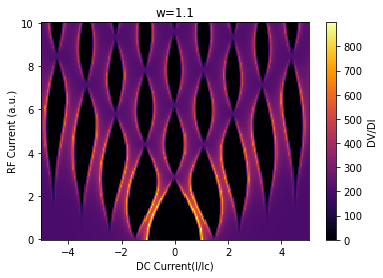

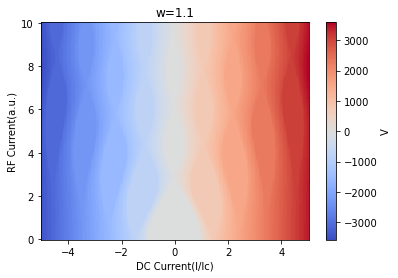

file saved


In [65]:
plt.figure()
plt.pcolor(IDC_array, IRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current(I/Ic)")
plt.ylabel("RF Current (a.u.)")
plt.colorbar(label = "DV/DI")
plt.title("w="+str(w_rf))
plt.savefig("DVDI_"+str(w_rf)+".pdf")
plt.show()
                
plt.figure()
plt.pcolor(IDC_array, IRF_array, WB_Freq/w_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current(I/Ic)")
plt.ylabel("RF Current(a.u.)")
plt.colorbar(label = "V")
plt.title("w="+str(w_rf))
plt.savefig("V_"+"w="+str(w_rf)+".pdf")
plt.show()

savemat("data_w="+str(w_rf)+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array, 'w_rf':w_rf,'Vmatrix':WB_Freq,'DVDI':DVDI})
print('file saved')

In [66]:
from scipy.io import loadmat

### Just plotting

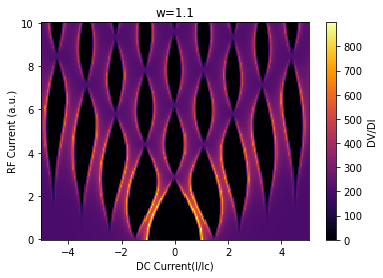

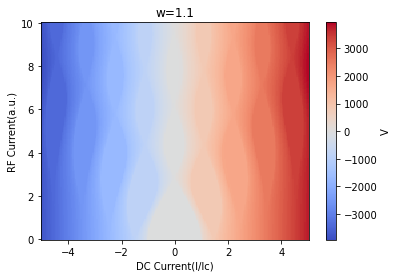

In [67]:
data=loadmat("data_w=1.1.mat")
IDC=np.squeeze(data['IDC'])
IRF=np.squeeze(data['IRF'])
DVDI=data['DVDI']
V=data['Vmatrix']
w_rf=np.squeeze(data['w_rf'])
plt.figure()
plt.pcolor(IDC, IRF, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current(I/Ic)")
plt.ylabel("RF Current (a.u.)")
plt.colorbar(label = "DV/DI")
plt.title("w="+str(w_rf))
plt.savefig("DVDI_"+str(w_rf)+".pdf")
plt.show()
                
plt.figure()
plt.pcolor(IDC, IRF, V , cmap = 'coolwarm',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current(I/Ic)")
plt.ylabel("RF Current(a.u.)")
plt.colorbar(label = "V")
plt.title("w="+str(w_rf))
plt.savefig("V_"+"w="+str(w_rf)+".pdf")
plt.show()